<a href="https://colab.research.google.com/github/jiseon0516/pdm19/blob/main/py-pandas/pandas_6_iot_nano33_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pandas: access to the remote json from MongoDB
- The json file is generated on the fly from the express server of Node.js.
- The data stored in MongoDB are saved in the json file.
- The data are composed of three time series; temperature, humidity, and luminosity.


### nano33 데이터
- 소형 아두이노 보드: 블루투스 등 탑재
- 보드에서 5초마다 나오는 기본적인 환경 신호들을 MongoDB에 저장



### iot
- 순간의 데이터를 수집하고 처리하는 기술 
- 머신러닝, 딥러닝: 데이터를 처리하는 것

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc

## [데이터 로드 1.]
- loading real-time json file from MongoDB via web

- http://chaos.inje.ac.kr:3030/client_33.html

In [54]:
#실시간으로 데이터가 데이터베이스에 저장되고 있음
#실시간 서버에 접근해 지금까지 데이터베이스에 저장된 모든 데이터를 특별한 파일 포맷인 json파일 형태로 끌어올 수 있음
#시간이 많이 걸려 사용x

# loading real-time json file from MongoDB via web (CORS, port=3030)
# url="http://chaos.inje.ac.kr:3030/iot"
# df=pd.read_json(url)
# print('Large IoT data was retrieved successfully from MongoDB!')

## [데이터 로드 2.]
- Load the compressed data from github.com

In [32]:
# Load the compressed data from github.com
# https://towardsdatascience.com/4-awesome-ways-of-loading-ml-data-in-google-colab-9a5264c61966
# url_zip = 'https://github.com/Redwoods/Py/raw/master/pdm2020/my-note/py-pandas/data/iot_data_201005_raw.zip'
!wget https://github.com/Redwoods/Py/raw/master/pdm2020/my-note/py-pandas/data/iot_data_201005_raw.zip #wget이라는 리눅스 함수를 이용해 zip파일을 가져옴
!unzip iot_data_201005_raw.zip #unzpi함수로 zip 압축 풀어버림
#풀린 압축파일 이름: iot_data_201005_raw.csv 

--2021-10-10 11:26:10--  https://github.com/Redwoods/Py/raw/master/pdm2020/my-note/py-pandas/data/iot_data_201005_raw.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Redwoods/Py/master/pdm2020/my-note/py-pandas/data/iot_data_201005_raw.zip [following]
--2021-10-10 11:26:10--  https://raw.githubusercontent.com/Redwoods/Py/master/pdm2020/my-note/py-pandas/data/iot_data_201005_raw.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8389520 (8.0M) [application/zip]
Saving to: ‘iot_data_201005_raw.zip.1’

iot_data_201005_raw 100%[===================>]   8.00M  --.-KB/s    in 0.09s   

2021-10-10 

In [33]:
df = pd.read_csv("iot_data_201005_raw.csv", index_col=False) #pandas의 read_csv 함수를 이용해 읽어옴
#index_col=False: default 인덱스 사용
df.head()
#데이터가 나올 때마다 고유한 포맷, data 나온 시간, 온도, 습도, 조도, 대기압, 빛의 r 비율, 빛의 g 비율, 빛의 b 비율, 제대로 수집되었는가의 varidation

,Unnamed: 0,_id,date,temperature,humidity,luminosity,pressure,r_ratio,g_ratio,b_ratio,__v
0,0,5f52e97f3d26c027a020fcd1,2020-09-05 10:27:27.873,29.7,50.6,47,1008.8,31.9,36.2,31.9,0
1,1,5f52e9843d26c027a020fcd2,2020-09-05 10:27:32.902,29.7,51.5,47,1008.8,33.3,35.4,31.3,0
2,2,5f52e9893d26c027a020fcd3,2020-09-05 10:27:37.933,29.7,52.1,47,1008.8,33.3,35.4,31.3,0
3,3,5f52e98e3d26c027a020fcd4,2020-09-05 10:27:42.964,29.7,52.5,47,1008.8,31.9,36.2,31.9,0
4,4,5f52e9933d26c027a020fcd5,2020-09-05 10:27:47.996,29.7,52.2,47,1008.8,31.9,36.2,31.9,0


In [34]:
df.head()

,Unnamed: 0,_id,date,temperature,humidity,luminosity,pressure,r_ratio,g_ratio,b_ratio,__v
0,0,5f52e97f3d26c027a020fcd1,2020-09-05 10:27:27.873,29.7,50.6,47,1008.8,31.9,36.2,31.9,0
1,1,5f52e9843d26c027a020fcd2,2020-09-05 10:27:32.902,29.7,51.5,47,1008.8,33.3,35.4,31.3,0
2,2,5f52e9893d26c027a020fcd3,2020-09-05 10:27:37.933,29.7,52.1,47,1008.8,33.3,35.4,31.3,0
3,3,5f52e98e3d26c027a020fcd4,2020-09-05 10:27:42.964,29.7,52.5,47,1008.8,31.9,36.2,31.9,0
4,4,5f52e9933d26c027a020fcd5,2020-09-05 10:27:47.996,29.7,52.2,47,1008.8,31.9,36.2,31.9,0


In [35]:
df.tail()
#5초 간격으로 데이터 저장

,Unnamed: 0,_id,date,temperature,humidity,luminosity,pressure,r_ratio,g_ratio,b_ratio,__v
511657,511657,5f7a733111799622e801a745,2020-10-05 10:13:21.563,30.5,31.2,413,1009.2,34.2,34.0,31.8,0
511658,511658,5f7a733611799622e801a746,2020-10-05 10:13:26.595,30.4,31.1,412,1009.1,34.2,33.9,31.9,0
511659,511659,5f7a733b11799622e801a747,2020-10-05 10:13:31.627,30.4,31.0,413,1009.1,34.2,34.0,31.8,0
511660,511660,5f7a734011799622e801a748,2020-10-05 10:13:36.659,30.4,31.0,414,1009.1,34.0,34.0,32.0,0
511661,511661,5f7a734511799622e801a749,2020-10-05 10:13:41.690,30.4,30.8,408,1009.1,34.0,34.0,32.0,0


In [36]:
df.shape, type(df) #행렬 형태로 저장되어 있음

((511662, 11), pandas.core.frame.DataFrame)

In [37]:
df['date'][:1],df['date'][-1:]

(0    2020-09-05 10:27:27.873
 Name: date, dtype: object, 511661    2020-10-05 10:13:41.690
 Name: date, dtype: object)

In [38]:
df.info() #데이터의 정보
#r,g,b 비율은 절반 밖에 안 됨 - 조도는 rgb 모두 섞여있음
#조도에서 r 성분 값만 계산해야 되는데 밤에는 조도가 0이 됨. -> 밤은 분모가 0이 되어 null이 되어버림 -> 데이터 값은 절반 밖에 안 됨

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511662 entries, 0 to 511661
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   511662 non-null  int64  
 1   _id          511662 non-null  object 
 2   date         511662 non-null  object 
 3   temperature  511662 non-null  float64
 4   humidity     511662 non-null  float64
 5   luminosity   511662 non-null  int64  
 6   pressure     511662 non-null  float64
 7   r_ratio      259586 non-null  float64
 8   g_ratio      259586 non-null  float64
 9   b_ratio      259586 non-null  float64
 10  __v          511662 non-null  int64  
dtypes: float64(6), int64(3), object(2)
memory usage: 42.9+ MB


In [39]:
df.describe() #데이터의 통계적 요약

,Unnamed: 0,temperature,humidity,luminosity,pressure,r_ratio,g_ratio,b_ratio,__v
count,511662.000000,511662.000000,511662.000000,511662.000000,511662.000000,259586.000000,259586.000000,259586.000000,511662.0
mean,255830.500000,31.151488,49.233919,87.690763,1005.716766,31.617429,34.924630,33.451469,0.0
std,147704.241054,1.000845,6.199525,193.338066,5.776317,3.943971,2.777365,5.008596,0.0
min,0.000000,28.500000,23.800000,0.000000,955.500000,0.000000,0.000000,0.000000,0.0
25%,127915.250000,30.500000,44.300000,0.000000,1004.200000,31.100000,34.500000,32.000000,0.0
50%,255830.500000,31.200000,48.800000,2.000000,1006.800000,32.200000,35.000000,32.800000,0.0
75%,383745.750000,31.800000,54.100000,70.000000,1008.700000,33.300000,35.500000,33.600000,0.0
max,511661.000000,34.500000,70.000000,1143.000000,1012.200000,100.000000,50.000000,100.000000,0.0


In [40]:
#데이터프레임은 다시 csv 파일로 저장될 수 있음
# Save iot data in csv file.
# df.to_csv('iot_data_201005_raw.csv')

## Check data
- NaN: 숫자 대신 다른 데이터가 들어갔는지 확인
- missing value: 비어있는 데이터가 있는지 확인

In [41]:
df.isnull().sum() #/df.shape[0]*100

Unnamed: 0          0
_id                 0
date                0
temperature         0
humidity            0
luminosity          0
pressure            0
r_ratio        252076
g_ratio        252076
b_ratio        252076
__v                 0
dtype: int64

In [42]:
df.isna().sum()

Unnamed: 0          0
_id                 0
date                0
temperature         0
humidity            0
luminosity          0
pressure            0
r_ratio        252076
g_ratio        252076
b_ratio        252076
__v                 0
dtype: int64

## Replace NaN with mean: Imputation
- NaN ==>> 33.3 (100/3)
- r,g,b가 동등하게 섞이면 백색광 -> 동일한 비율로 채워 넣음


In [43]:
df=df.fillna(33.3) #NaN 값은 33.3%로 채워줌
df.isna().sum() #NaN이 있는지 확인

Unnamed: 0     0
_id            0
date           0
temperature    0
humidity       0
luminosity     0
pressure       0
r_ratio        0
g_ratio        0
b_ratio        0
__v            0
dtype: int64

In [44]:
# for whole dataframe
# df = df.replace(np.nan, 33.3) #replace 함수로 모든 NaN은 33.3%로 바꿔줌
# df.isnull().sum()

## IoT data were cleaned!

## New DataFrame : iot_data
### Dataframe with date and sensor values(temperature, humidity, luminosity, pressure, r, g, b)
- 데이터프레임 재구성: iot_data

In [45]:
#  select columns - 사용할 열 리스트로 지정
cols = ['date', 'temperature', 'humidity', 'luminosity', 'pressure', 'r_ratio', 'g_ratio', 'b_ratio']

In [46]:
# Make iot data
iot_data = df[cols] #지정한 열로 데이터프레임 새로 구성(8개 항목)

In [47]:
iot_data.shape

(511662, 8)

In [48]:
iot_data.head()  # date와 7 개의 신호를 확인.

,date,temperature,humidity,luminosity,pressure,r_ratio,g_ratio,b_ratio
0,2020-09-05 10:27:27.873,29.7,50.6,47,1008.8,31.9,36.2,31.9
1,2020-09-05 10:27:32.902,29.7,51.5,47,1008.8,33.3,35.4,31.3
2,2020-09-05 10:27:37.933,29.7,52.1,47,1008.8,33.3,35.4,31.3
3,2020-09-05 10:27:42.964,29.7,52.5,47,1008.8,31.9,36.2,31.9
4,2020-09-05 10:27:47.996,29.7,52.2,47,1008.8,31.9,36.2,31.9


In [49]:
iot_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511662 entries, 0 to 511661
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   date         511662 non-null  object 
 1   temperature  511662 non-null  float64
 2   humidity     511662 non-null  float64
 3   luminosity   511662 non-null  int64  
 4   pressure     511662 non-null  float64
 5   r_ratio      511662 non-null  float64
 6   g_ratio      511662 non-null  float64
 7   b_ratio      511662 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 31.2+ MB


In [50]:
iot_data.isna().sum()

date           0
temperature    0
humidity       0
luminosity     0
pressure       0
r_ratio        0
g_ratio        0
b_ratio        0
dtype: int64

In [51]:
# Save iot data in csv file.
iot_data.to_csv('iot_data_201005_clean.csv')

## EDA
- 중간고사: csv 파일로 특정 데이터를 준 후 데이터를 가지고 배운 파이썬 모듈들을 사용해 EDA를 수행하고 최종적으로 수행된 결과를 깃허브로

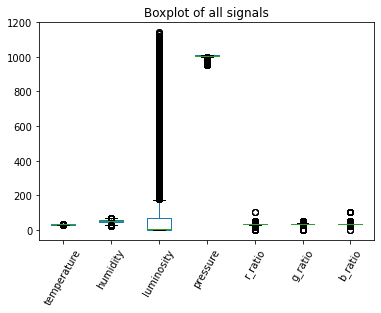

In [52]:
# Plot boxplot - 온도, 습도, 조도를 리스트로 묶어 boxplot으로 그리기
# iot_data[['temperature','humidity','luminosity']].plot.box(title='Boxplot of temperature, humidity, and luminosity')
#조도는 0~1200사이로 반함, 습도는 10~90, 온도는 30도 부근에서 변함

#온도, 습도, 조도를 loc함수 이용해 그리기
# iot_data.loc[:,'temperature':'luminosity'].plot.box(title='Boxplot of temperature, humidity, and luminosity')
#온도~조도까지, 데이터프레임에서 loc함수를 쓸 때 인덱스를 쓰면 맨 마지막은 포함되지 않지만 레이블 사용 시 마지막 포함됨

#7개의 신호를 iloc함수 이용해 그리기
iot_data.iloc[:,1:].plot.box(title='Boxplot of all signals')
plt.xticks(rotation=60)
plt.show()

### Plot time series of sensor data

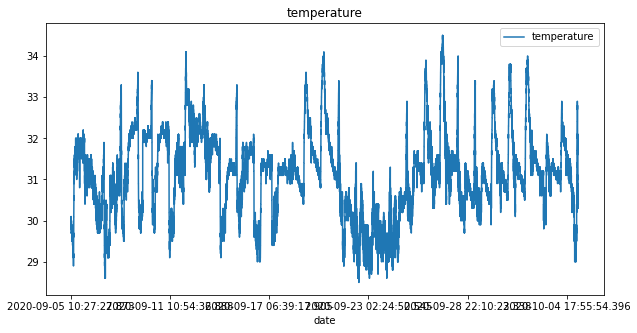

In [ ]:
#한달동안의 온도 그래프 그리기
iot_data.plot(x='date', y='temperature', figsize=(10,5), title='temperature')
# plt.xticks(rotation=60)
plt.show()

### Set style of graph
- plt.style.use('fivethirtyeight')
- plt.style.use('ggplot')

In [ ]:
plt.style.available

In [ ]:
iot_data.plot(x='date', y='temperature', figsize=(10,5), title='temperature')
plt.style.use('seaborn-pastel') # 'seaborn-pastel', 'fivethirtyeight'
plt.show()

In [ ]:
iot_data.plot(x='date', y='temperature', figsize=(10,5), title='temperature')
plt.style.use('ggplot')
plt.show()

In [ ]:
# restore default style
plt.style.use('default')

In [ ]:
iot_data.plot(x='date', y='humidity', figsize=(10,5), title='humidity')
plt.show()

In [ ]:
iot_data.plot(x='date', y='luminosity', figsize=(10,5), title='luminosity')
plt.show()

In [ ]:
iot_data.plot(x='date', y='pressure', figsize=(10,5), title='pressure')
# plt.xticks(rotation=90)
plt.show()

#### 다중그래프 (multiple graphs)

In [ ]:
# Plot of ['temperature','humidity']
iot_data.plot(x='date', y=['temperature','humidity'], figsize=(10,5), title='temperature and humidity')

In [ ]:
# Plot of ['temperature','humidity','luminosity','pressure']
iot_data.plot(x='date', y=['temperature','humidity','luminosity','pressure'], figsize=(10,6), 
             title='temperature, humidity, luminosity and pressure')
plt.show()

#### Plot the mean of sensor data

In [ ]:
iot_data[['temperature','humidity','luminosity']].mean()  

In [ ]:
iot_data[['temperature','humidity','luminosity']].mean().plot.bar(figsize=(8,5), 
                                                                  title="Mean of temperature, humidity, and luminosity")

In [ ]:
plt.style.use('seaborn-pastel')   # fivethirtyeight, ggplot
iot_data[['temperature','humidity','luminosity']].mean().plot.bar(figsize=(6,3), 
                                                                  title="Mean of temperature, humidity, and luminosity")

# Advanced graphics using pandas

### Plot the change of sensor data over various time spans.

> time span: 60 sec, 1 hour, 1 day, 1 week

#### Set date as index of timestamp

In [ ]:
iot_data.head()

In [ ]:
iot_data.set_index('date',inplace=True)

In [ ]:
# Convert date index to Datetime index
iot_data.index = pd.to_datetime(iot_data.index)

In [ ]:
iot_data.info() # Range index -> timestamp(Datetime) index 

In [ ]:
iot_data.head()

In [ ]:
# Estimate the mean of the iot data for every minute
iot_data.resample('60S').mean()

In [ ]:
#  Plot mean of the iot data per every minute
iot_data.resample('60S').mean().plot(figsize=(8,5), 
                                     title='Minutely change of temperature, humidity, and luminosity')
plt.legend(bbox_to_anchor=(1.02, 1.0))

In [ ]:
#  Plot mean of the iot data per every minute
iot_data[['r_ratio', 'g_ratio', 'b_ratio']].resample('60S').mean().plot(figsize=(10,5), 
                                     title='Minutely change of R, G, B',
                                     color="rgb")

In [ ]:
# Estimate the mean of iot data for every hour
iot_data.resample('H').mean()  # mean per each hour

In [ ]:
iot_data.resample('H').mean().shape, iot_data.resample('H').mean().info()

In [ ]:
#  Plot mean of the iot data per every hour 
iot_data.resample('H').mean().plot(figsize=(10,6), 
                                   title='Hourly change of temperature, humidity, and luminosity') #, 
                                #    ylim=[0,500])

In [ ]:
#  Plot mean of the iot data per every minute
iot_data[['r_ratio', 'g_ratio', 'b_ratio']].resample('H').mean().plot(figsize=(10,6), 
                                    color = ['red', 'green', 'blue'],
                                    title='Hourly change of R, G, B')

## [도전하기]  하루 24 시간 동안의 R,G,B 변화 그래프를 그려보시오.

In [ ]:
# Estimate the mean of iot data for every day
iot_data.resample('D').mean()

In [ ]:
iot_data.resample('D').mean().shape, iot_data.resample('D').mean().info()

In [ ]:
iot_data.resample('D').mean().head()

In [ ]:
iot_data_day=iot_data.resample('D').mean()
iot_data_day.head()

In [ ]:
iot_data_day.info()

In [ ]:
#  Plot mean of the iot data per every day
iot_data.resample('D').mean().plot(kind='bar', #marker='o', ms=6, figsize=(12,6), 
                                   title='Daily change of temperature, humidity, and luminosity')

In [ ]:
#  Plot mean of the iot data per every minute
iot_data[['r_ratio', 'g_ratio', 'b_ratio']].resample('D').mean().plot(figsize=(10,6), 
                                    color = ['r','g','b'], #marker='o', ms=6, 
                                    title='Dayly change of R, G, B')

## 위의 그래프를 파이 그래프로 그려보시오.

In [ ]:
#  Plot mean of the iot data per every day
# df.plot.pie(subplots=True, figsize=(6, 3))
iot_rgb = iot_data[['r_ratio', 'g_ratio', 'b_ratio']].resample('D').mean()
iot_rgb.head()


In [ ]:
iot_rgb.iloc[0],iot_rgb.iloc[1]

In [ ]:
iot_rgb.index, len(iot_rgb.index)

In [ ]:
# Convert timestamp to date string
iot_rgb.index[0].strftime('%Y-%m-%d')

In [ ]:
iot_rgb.iloc[0].plot.pie(subplots=True, figsize=(5,3), 
                         colors = ['red', 'green', 'blue'], labeldistance=None, 
                         autopct='%.2f', 
                         title='Daily change of R, G, B')
plt.ylabel(iot_rgb.index[0].strftime('%Y-%m-%d'))
plt.show()

## Weekly graph

In [ ]:
# Estimate the mean of iot data for every week
iot_data.resample('W').mean()

In [ ]:
#  Plot mean of the iot data per every week
iot_data.resample('W').mean().plot(kind='bar', #marker='o', ms=10, 
                                   figsize=(12,6), 
                                   title='Weekly change of temperature, humidity, and luminosity, pressure, R, G , B')

In [ ]:
#  Plot mean of the iot data per every week
iot_data['temperature'].resample('W').mean().plot(kind='bar', #marker='o', ms=10, 
                                   figsize=(12,6), 
                                   title='Weekly change of temperature')

### 다중 파이 그래프
- https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=iot_rgb.index.size, figsize=(20,5))

fig.subplots_adjust(hspace=0.5, wspace=0.05)

for row in range(iot_rgb.index.size):
    fig.add_subplot(axs[row] )
    plt.pie(iot_rgb.iloc[row],
            colors = ['red', 'green', 'blue'], labeldistance=None, 
                         autopct='%.2f')  #, labels=df.columns)
    plt.ylabel(iot_rgb.index[row].strftime('%Y-%m-%d'))
    # plt.axis('off')

In [ ]:
for row in ax:
    for col in row:
        col.plot(x, y)

In [ ]:
fig, axs = plt.subplots(nrows=(iot_rgb.index.size-1)//7+1, ncols=7, figsize=(16,16))
# axs.set_axis_off()

fig.subplots_adjust(hspace=0.5, wspace=0.05)
idx=0
for row in axs:
    # fig.add_subplot(axs[row] )
    # fig.add_subplot(5, 7, row+1)
    # ax = axs[row]
    for col in row:
        col.pie(iot_rgb.iloc[idx],
            colors = ['red', 'green', 'blue'], labeldistance=None, 
                         autopct='%.2f')  #, labels=df.columns)
        
        col.set_ylabel(iot_rgb.index[idx].strftime('%Y-%m-%d'),fontsize=12)
        idx = idx + 1

        if idx == iot_rgb.index.size:
            idx = iot_rgb.index.size-1
        
    # plt.axis('off')
    # plt.axis('off')
    # plt.grid(False)
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=(iot_rgb.index.size-1)//7+1, ncols=7, figsize=(16,16))
# axs.set_axis_off()

fig.subplots_adjust(hspace=0.5, wspace=0.05)

for row in range(iot_rgb.index.size):
    # fig.add_subplot(axs[row] )
    fig.add_subplot(5, 7, row+1)
    ax = axs[row]
    plt.pie(iot_rgb.iloc[row],
            colors = ['red', 'green', 'blue'], labeldistance=None, 
                         autopct='%.2f')  #, labels=df.columns)
    plt.ylabel(iot_rgb.index[row].strftime('%Y-%m-%d'),fontsize=14)
    # plt.axis('off')
    # plt.axis('off')
    plt.grid(False)
plt.show()

### animate pie chart
- https://towardsdatascience.com/learn-how-to-create-animated-graphs-in-python-fce780421afe
- https://pinkwink.kr/1090

In [ ]:
iot_rgb.columns

In [ ]:
fig,ax = plt.subplots()
explode=[0.01,0.01,0.01] #pop out each slice from the pie
def getmepie(i):
    iv = min(i, len(iot_rgb.index)-1)
    # def absolute_value(val): #turn % back to a number
    #     a  = np.round(val/100.*df1.head(i).max().sum(), 0)
    #     return int(a)
    ax.clear()
    plot = iot_rgb.iloc[iv].plot.pie(y=iot_rgb.columns, autopct='%.2f', label='',explode = explode, colors=['r','g','b'], shadow = True)
    plot.set_title('Date\n' + str(iot_rgb.index[iv].strftime('%Y-%m-%d')), fontsize=12)

# import matplotlib.animation as ani
animator = animation.FuncAnimation(fig, getmepie, interval = 200)
# plt.show()
rc('animation', html='html5')
animator

## 와, Great!